In [1]:
# Importando dependências

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.tree import DecisionTreeRegressor  
import math
import os
! pip install patool
import patoolib

In [2]:
# Descomprimindo arquivo .rar e lendo o dataset
try:
    patoolib.extract_archive("vehicles.rar", outdir=os.getcwd())
    os.remove("vehicles.rar")
except:
    pass
Dataset = pd.read_csv('vehicles.csv')
Dataset = Dataset.iloc[28: , :]
Dataset.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500
32,7316343444,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,...,NaN,pickup,black,https://images.craigslist.org/00V0V_ftJbKrOgdi...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500
33,7316304717,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,...,NaN,pickup,silver,https://images.craigslist.org/00E0E_iKN07Sh7ou...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500
34,7316285779,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,35000,2019.0,toyota,tacoma,excellent,6 cylinders,...,NaN,truck,grey,https://images.craigslist.org/00101_dXoZTH7iVm...,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500
35,7316257769,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500
36,7316133914,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,...,NaN,other,red,https://images.craigslist.org/00U0U_kKYnS1LWh8...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500
37,7316130053,https://auburn.craigslist.org/cto/d/opelika-19...,auburn,https://auburn.craigslist.org,4500,1992.0,jeep,cherokee,excellent,6 cylinders,...,NaN,NaN,NaN,https://images.craigslist.org/01010_7EM2aot64G...,192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...,NaN,al,32.6454,-85.378300,2021-05-03T07:38:05-0500


# Quanto vale seu carro usado no Craigslist?

### A partir da análise de dados como quilometragem, ano do modelo, estado de conservação, tipo de combustível, entre outros, pretendemos prever o preço de revenda de um carro na plataforma Craigslist.   

In [3]:
# Remoção de outliers: Removeremos todas as linhas que tenham um preço com Z score(Número de desvios padrão
# de distância da média) maior ou igual a 3

z_scores = stats.zscore(Dataset.price)
abs_z = np.abs(z_scores)
Dataset['sigma'] = abs_z

Dataset = Dataset.loc[Dataset.sigma < 3,:]



# Análise exploratória -- Preços

Preço é a variável target do modelo. Assim, é de interesse analisar quais são os fatores fundamentais que influenciam em seu valor. Nesse sentido, através de gráficos de dispersão, histogramas e outras ferramentas estatísticas, determinaremos as features a serem consideradas.

clean         0.967701
rebuilt       0.017245
salvage       0.009240
lien          0.003397
missing       0.001944
parts only    0.000473
Name: title_status, dtype: float64


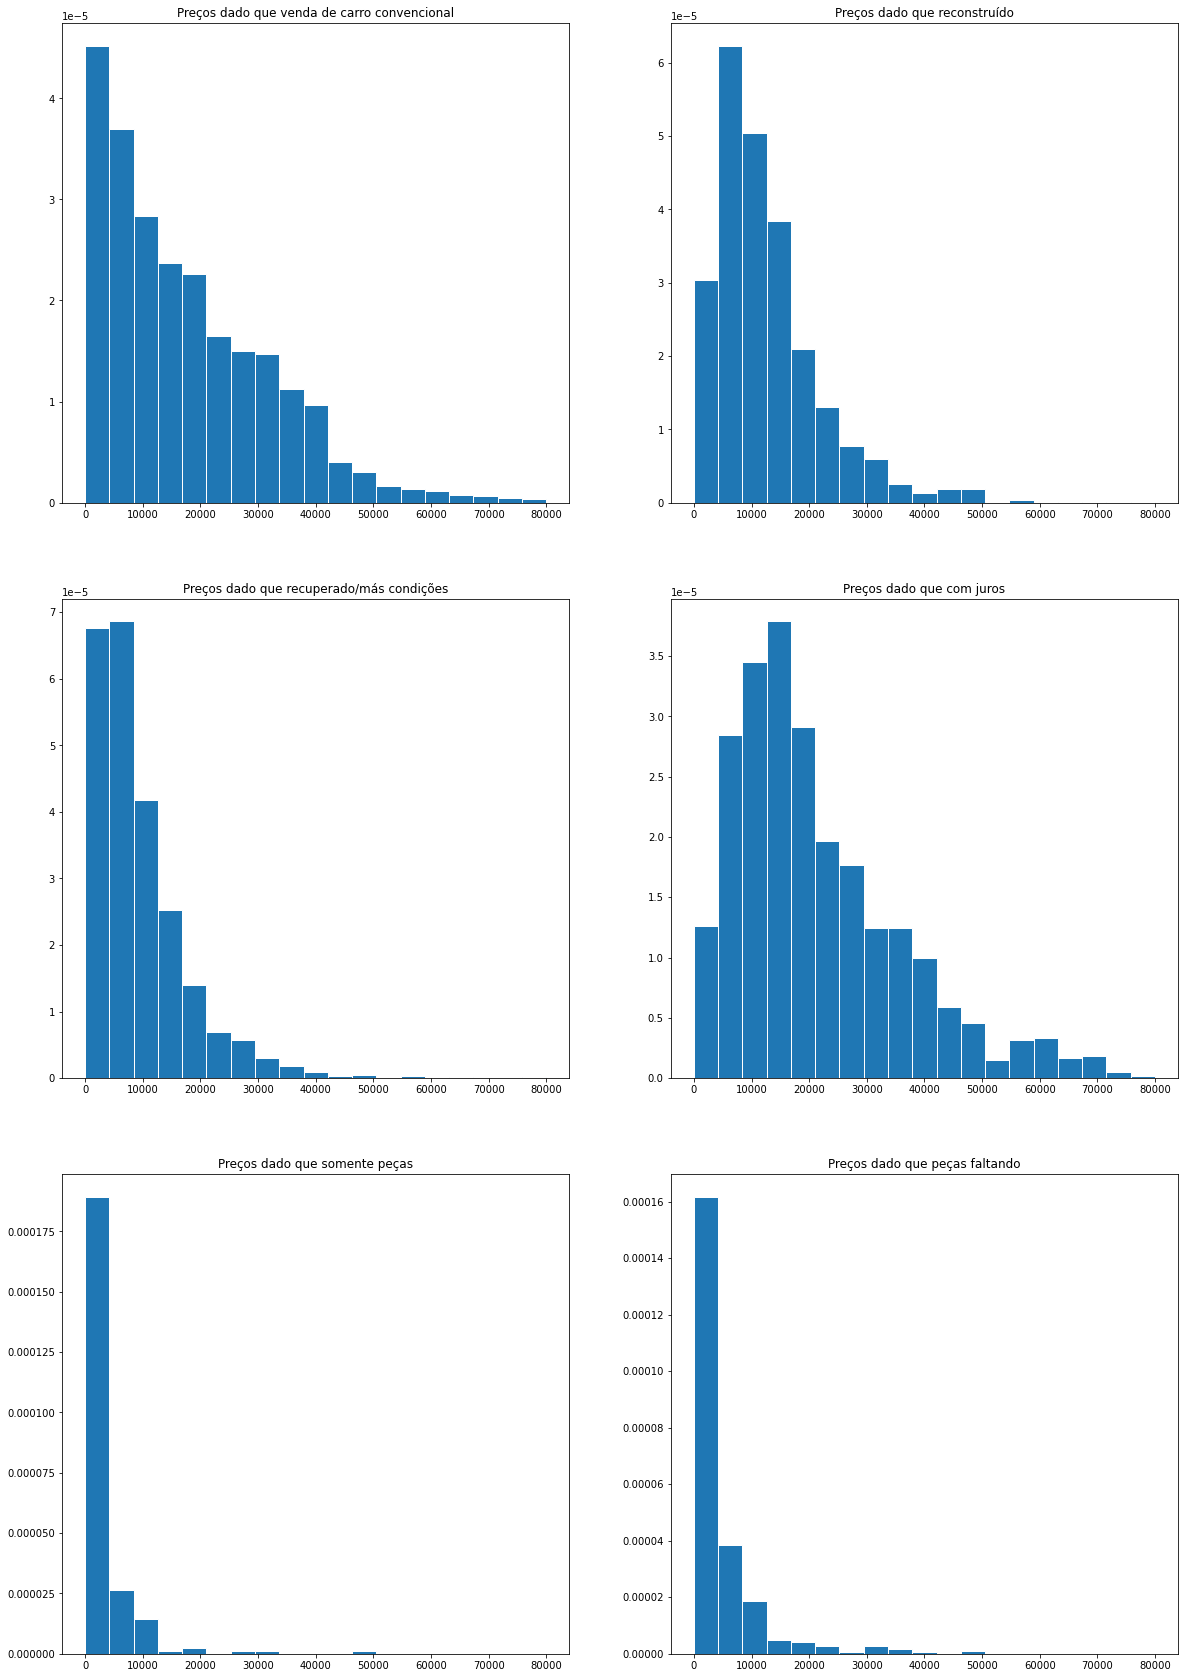

In [4]:
# Primeiramente, devemos decidir quais são as condições que o modelo assume. Imaginamos que venda de peças de carros
# ou de carros com peças faltando são casos significativamente diferentes do que a de um carro convencional. 

print(Dataset.title_status.value_counts(normalize=True))

# Para observar as diferenças:

bins = np.linspace(0,8e+4,20)

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dado que venda de carro convencional')
plt.hist(Dataset.loc[Dataset.title_status == 'clean']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dado que reconstruído')
plt.hist(Dataset.loc[Dataset.title_status == 'rebuilt']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dado que recuperado/más condições')
plt.hist(Dataset.loc[Dataset.title_status == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dado que com juros')
plt.hist(Dataset.loc[Dataset.title_status == 'lien']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dado que somente peças')
plt.hist(Dataset.loc[Dataset.title_status == 'parts only']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dado que peças faltando')
plt.hist(Dataset.loc[Dataset.title_status == 'missing']['price'],bins,edgecolor='white',density=True)
plt.show()



# Conclusão:

Percebe-se que os preços de peças, carros com peça faltando e em más condições destoam bastante do convencional por praticamente não serem vendidos à valores mais altos. Já no caso de carros "com juros" (car lien é a venda de um carro em parcelas, na qual o vendedor cobra juros por segurança, podendo recuperar o carro caso não seja pago), eles costumam ter valores maiores que carros convencionais. Para carros reconstruídos, eles não cotumam ser vendidos por preços muito baixos, mas tendem a ter preços menores que o convencional na maioria dos casos.

Como a maioria (cerca de 96%) da base de dados é composta por carros convencionais, e as categorias restantes possuem distribuições significativamente diferentes, escolhemos filtrar o modelo para venda de carros convencionais.

count    372813.000000
mean      19198.605180
std       15435.202175
min           1.000000
25%        7495.000000
50%       15900.000000
75%       27990.000000
max      470000.000000
Name: price, dtype: float64


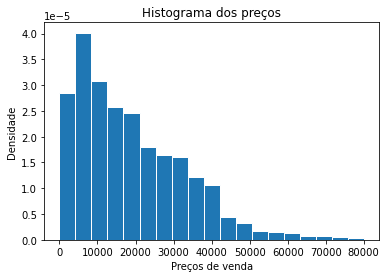

In [5]:
#Retirando preços excepcionais (nulos ou acima de 500000 dólares)
Dataset = Dataset.loc[Dataset['price'] > 0]
Dataset = Dataset.loc[Dataset['price'] < 0.5*(10**6)]

# Histograma de preços 
dados = Dataset.loc[Dataset.title_status == 'clean',:]

# Valores de interesse para basear as faixas
print(dados.price.describe())

bins = np.linspace(0,8e+4,20)

plt.hist(dados.price,bins=bins,edgecolor='white',density=True)
plt.title('Histograma dos preços')
plt.xlabel('Preços de venda')
plt.ylabel('Densidade')
plt.show()

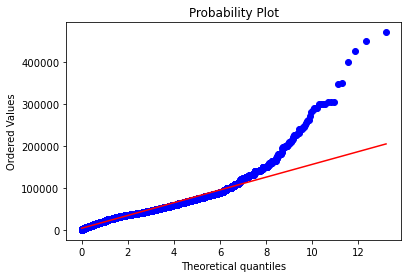

In [6]:
# O gráfico se assemelha com uma exponencial, para verificar temos que: 

stats.probplot(dados.price,dist='expon',plot=plt)
plt.show()

-0.174654412433851


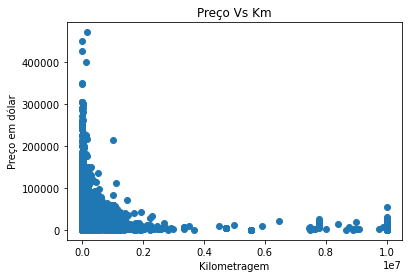

In [7]:
# Kilometragem e preço são relacionados?

print(dados.price.corr(dados.odometer))

plt.scatter(dados.odometer,dados.price)
plt.title('Preço Vs Km')
plt.ylabel('Preço em dólar')
plt.xlabel('Kilometragem')
plt.show()

# Correlação bem fraca e negativa

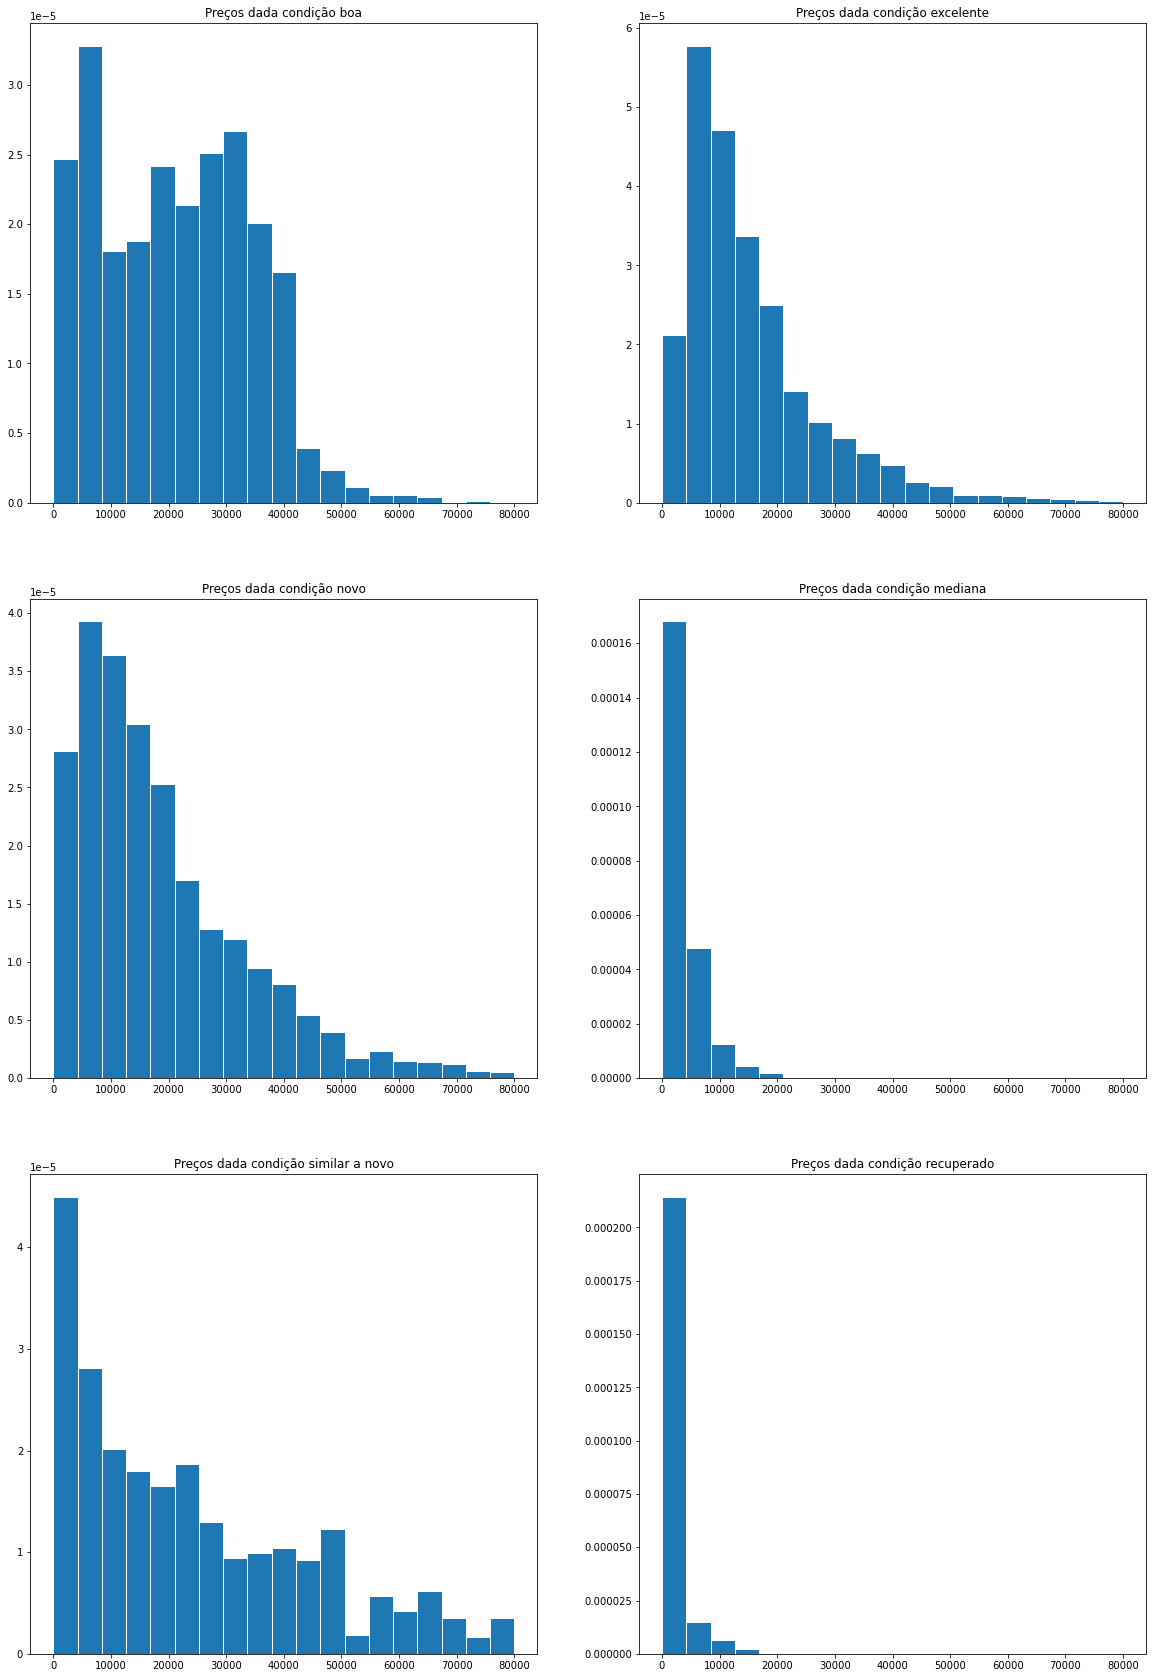

In [8]:
# Preço e condição se relacionam?

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dada condição boa')
plt.hist(dados.loc[dados.condition == 'good']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dada condição excelente')
plt.hist(dados.loc[dados.condition == 'excellent']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dada condição novo')
plt.hist(dados.loc[dados.condition == 'like new']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dada condição mediana')
plt.hist(dados.loc[dados.condition == 'fair']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dada condição similar a novo')
plt.hist(dados.loc[dados.condition == 'new']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dada condição recuperado')
plt.hist(dados.loc[dados.condition == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.show()


automatic    0.776875
other        0.163108
manual       0.060018
Name: transmission, dtype: float64


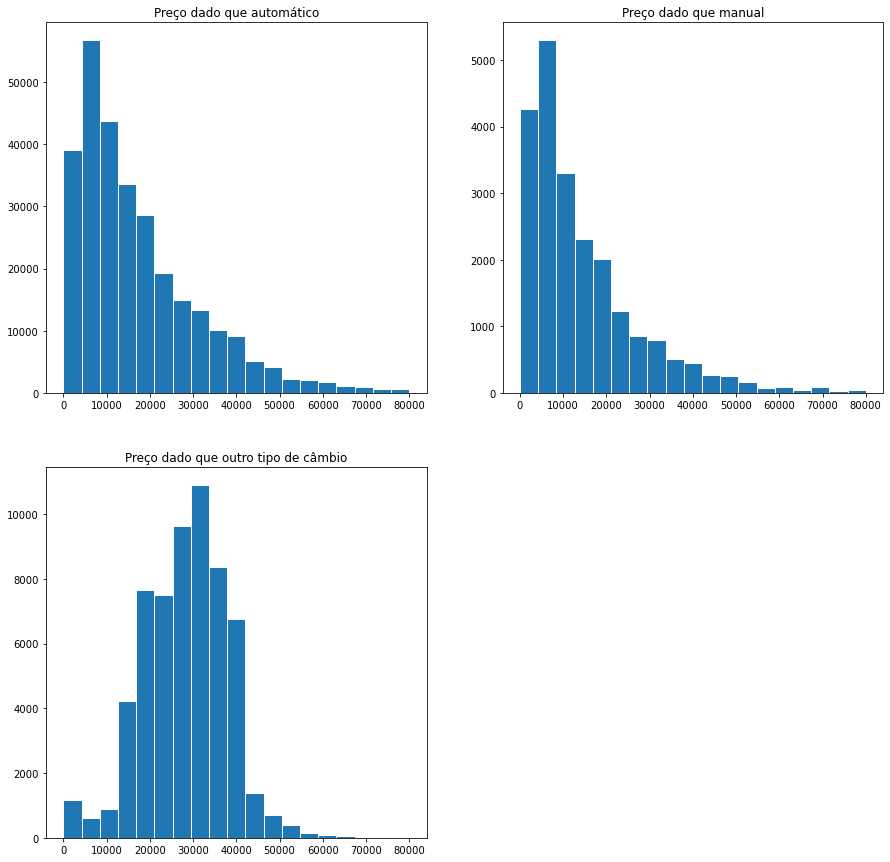

In [9]:
# Preço e tipo de câmbio se relacionam?

print(dados.transmission.value_counts(normalize=True))

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.hist(dados.loc[dados.transmission=='automatic']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que automático')
plt.subplot(222)
plt.hist(dados.loc[dados.transmission=='manual']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que manual')
plt.subplot(223)
plt.hist(dados.loc[dados.transmission=='other']['price'],bins=bins,edgecolor='white')
plt.title('Preço dado que outro tipo de câmbio')
plt.show()

# Percebe-se que carros automáticos e manuais tem uma distribuição relativamente parecida, diferentemente
# dos outros tipos, que destoam do padrão de preços.



0.32926355668944185


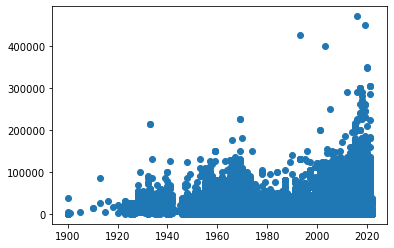

In [10]:
# Preço e ano de fabricação se relacionam?

print(dados.price.corr(dados.year))
plt.scatter(dados.year,dados.price)
plt.show()

# Associação fraca e positiva

In [11]:
dum = pd.get_dummies(Dataset, drop_first=False, columns=['year', 'title_status', 'condition', 'transmission', 'cylinders', 'fuel', 'type', 'paint_color', 'manufacturer', 'drive', 'size'])

X = dum.iloc[:, 25:]

results = sm.OLS(dum.price, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.831
Model:                            OLS   Adj. R-squared (uncentered):              0.831
Method:                 Least Squares   F-statistic:                              9452.
Date:                Mon, 29 Nov 2021   Prob (F-statistic):                        0.00
Time:                        21:27:15   Log-Likelihood:                     -4.1875e+06
No. Observations:              393894   AIC:                                  8.375e+06
Df Residuals:                  393689   BIC:                                  8.378e+06
Df Model:                         205                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
year_1920.0                  -1.121e+04   7090.161     -1.581      0.114   -2.51e+04    2689.722
year_1921.0                  -9327.1795   7090.248     -1.315      0.188   -2.32e+04    4569.495
year_1922.0                  -6384.0052   5791.772     -1.102      0.270   -1.77e+04    4967.693
year_1923.0                  -5939.0885   1688.648     -3.517      0.000   -9248.788   -2629.389
year_1924.0                  -3763.8138   3351.924     -1.123      0.261   -1.03e+04    2805.857
year_1925.0                  -1.038e+04   3551.564     -2.922      0.003   -1.73e+04   -3416.237
year_1926.0                  -1.032e+04   2517.561     -4.098      0.000   -1.53e+04   -5383.391
year_1927.0                  -7014.1135   1688.332     -4.154      0.000   -1.03e+04   -3705.033
year_1928.0                   6576.3097   1688.139      3.896      0.000    3267.607    9885.012
year_1929.0                  -1155.4847   1361.859     -0.848      0.396   -3824.687    1513.718
year_1930.0                   2358.0142   1249.090      1.888      0.059     -90.165    4806.193
year_1931.0                    159.9068   1349.653      0.118      0.906   -2485.372    2805.186
year_1932.0                    1.11e+04   1386.144      8.007      0.000    8382.335    1.38e+04
year_1933.0                   2.667e+04   2018.930     13.209      0.000    2.27e+04    3.06e+04
year_1934.0                   1.192e+04   1532.069      7.781      0.000    8918.525    1.49e+04
year_1935.0                    946.7293   2104.704      0.450      0.653   -3178.427    5071.885
year_1936.0                    -88.6635   1547.083     -0.057      0.954   -3120.900    2943.573
year_1937.0                   6750.6074   1222.157      5.524      0.000    4355.216    9145.999
year_1938.0                  -1928.8577   1665.758     -1.158      0.247   -5193.693    1335.978
year_1939.0                   3949.3049   1481.764      2.665      0.008    1045.091    6853.518
year_1940.0                   5767.4548   1152.664      5.004      0.000    3508.268    8026.642
year_1941.0                  -3443.8292   1256.986     -2.740      0.006   -5907.483    -980.175
year_1942.0                    567.7844   2688.440      0.211      0.833   -4701.477    5837.045
year_1943.0                  -9144.6533      1e+04     -0.912      0.362   -2.88e+04    1.05e+04
year_1944.0                   -1.74e+04   5794.401     -3.003      0.003   -2.88e+04   -6044.878
year_1945.0                  -4700.7253   7090.863     -0.663      0.507   -1.86e+04    9197.154
year_1946.0                  -6330.0866   1349.391     -4.691      0.000   -8974.853   -3685.320
year_1947.0                  -2793.0591   1285.032     -2.174      0.030  

In [12]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X, dum.price)
score = regressor.score(X, dum.price)
score

0.9291317657074678

In [45]:
#ano title_status condition transmission cylinders fuel type paint_color manufacturer drive size

def predictor(year, title_status, condition, transmission, cylinders, fuel, body_type, paint_color, manufacturer, drive, size):
    
    lista = []
    ano_checado = False
    status_checado = False
    condicao_checado = False
    transmissao_checado = False
    cilindros_checado = False
    combustivel_checado = False
    tipo_checado = False
    tinta_checado = False
    montadora_checado = False
    tracao_checado = False
    tamanho_checado = False


    
    for ano in X.columns[:103]:
        if year in ano:
            lista.append(1)
            ano_checado = True
        else:
            lista.append(0)
    
    
    for status in X.columns[103:109]:
        if title_status in status:
            lista.append(1)
            status_checado = True
        else:
            lista.append(0)
    
    for condicao in X.columns[109:115]:
        if condition in condicao:
            lista.append(1)
            condicao_checado = True
        else:
            lista.append(0)
            
    for transmissao in X.columns[115:118]:
        if transmission in transmissao:
            lista.append(1)
            transmissao_checado = True
        else:
            lista.append(0)
            
    for cilindros in X.columns[118:126]:
        if cylinders in cilindros:
            lista.append(1)
            cilindros_checado = True
        else:
            lista.append(0)
            
    for combustivel in X.columns[126:131]:
        if fuel in combustivel:
            lista.append(1)
            combustivel_checado = True
        else:
            lista.append(0)
            
    for tipo in X.columns[131:144]:
        if body_type == 'van' and tipo == 'type_van':
            lista.append(1)
            tipo_checado = True
        elif body_type in tipo:
            lista.append(1)
            tipo_checado = True
        else:
            lista.append(0)
            
    for tinta in X.columns[144:156]:
        if paint_color in tinta:
            lista.append(1)
            tinta_checado = True
        else:
            lista.append(0)
    
    for montadora in X.columns[156:199]:
        if manufacturer in montadora:
            lista.append(1)
            montadora_checado = True
        else:
            lista.append(0)
    
    for tracao in X.columns[199:201]:
        if drive in tracao:
            lista.append(1)
            tracao_checado = True
        else:
            lista.append(0)
    
    for tamanho in X.columns[201:]:
        if size == 'compact' and tamanho == 'size_compact':
            lista.append(1)
            tamanho_checado = True
        elif size in tamanho:
            lista.append(1)
            tamanho_checado = True
        else:
            lista.append(0)
    
    print([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])
    
    if any([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])==False:
        return ('input invalido')
            
    return regressor.predict([lista])
    


In [22]:
#print(Dataset['year'].values)

#print(X.columns.to_frame())
print(len(X.columns))
print(X.iloc[:, 204].name)

205
size_sub-compact


In [52]:
teste = predictor('2010', 'clean', 'fair', 'automatic', '8', 'gas', 'coupe', 'black', 'volkswagen', 'fwd', 'compact')

print(teste)

[True, True, True, True, True, True, True, True, True, True, True]
[1450.]
